In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [104]:
n_angles = 6
n_cells_x = 40
n_cells_y = 40
n_cells = n_cells_x*n_cells_y
width_x = 40
width_y = 40

sig_t = 1.0
sig_a = sig_t*0.01
sig_s = sig_t - sig_a
nu_sigf = sig_a*1.25

In [105]:
#Diffusion solution in 1D just to have an idea of what k I should get
D = 1/3/sig_t
Bg2 = (math.pi/(width_y+4*D))**2
print(D, Bg2)
k_diff = (nu_sigf)/(sig_a+D*Bg2)
print(k_diff)

0.3333333333333333 0.0057769536686917405
1.048160789408297


In [106]:
weights = np.zeros(3)
angles = np.zeros(3)

In [107]:
#Lathrop Even moment quadrature S-6
# The sum of the weights don't matter much in eigenvalue mode since we renormalize the flux

weights[0] = 0.1761263
weights[1] = 0.1572071
weights[2] = 0.1761263

angles[0] = 0.2666355
angles[1] = 0.6815076
angles[2] = 0.9261808

weight = np.zeros(n_angles)
eta = np.zeros(n_angles)
xi = np.zeros(n_angles)

#The mu, eta and xi angle cosines are picked such that the squares sum to 1
#e.g. if mu = 0.9261808, eta and xi must be equal to 0.2666355
eta[0] = angles[0]
xi[0] = angles[0]
weight[0] = weights[0]

eta[1] = angles[0]
xi[1] = angles[1]
weight[1] = weights[1]

eta[2] = angles[1]
xi[2] = angles[0]
weight[2] = weights[1]

eta[3] = angles[0]
xi[3] = angles[2]
weight[3] = weights[0]

eta[4] = angles[1]
xi[4] = angles[1]
weight[4] = weights[1]

eta[5] = angles[2]
xi[5] = angles[0]
weight[5] = weights[0]

In [108]:
#Build the right hand side
def rhs(phi,k):
    b = np.zeros([n_cells_x, n_cells_y])
    deltax = width_x/n_cells_x
    deltay = width_y/n_cells_y
    for i in range(n_cells_x):
        for j in range(n_cells_y):
            b[i,j] = phi[i,j]*sig_s + phi[i,j]*nu_sigf/k
    return b

In [109]:
# Use neutron balance to compute k
def balance(phi):
    f = 0.0
    a = 0.0
    deltax = width_x/n_cells_x
    deltay = width_y/n_cells_y
    for i in range(n_cells_x):
        for j in range(n_cells_y):
            f = f + phi[i,j]*nu_sigf
            a = a + phi[i,j]*sig_a
    f = f*deltax*deltay
    a = a*deltax*deltay
    return f,a

In [110]:
def sweep(b):
    # I tracked 4 leakage terms for debugging purposes, but one would be enough
    leakage1 = 0.0
    leakage2 = 0.0
    leakage3 = 0.0
    leakage4 = 0.0
    deltax = width_x/n_cells_x
    deltay = width_y/n_cells_y
    phi = np.zeros([n_cells_x,n_cells_y])
    n_total_angles = (n_angles+2)*n_angles/2
    for i in range(4): #for each quadrant      
        #for quadrant 1 (>0, >0)
        if (i==0):
            #hard-coded to 6 angles per quadrant
            for j in range(6):
                #probably not the most optimal way, but I sweep x first and must store all the angular fluxes in the y direction in each cell
                angular_flux_y = np.zeros([n_cells_y+1,n_cells_x])
                angular_flux_x = np.zeros(n_cells_x+1)
                for l in range(n_cells_y):
                    for k in range(n_cells_x):
                        angular_flux_x[k+1] = 2*(b[k,l] + 2*eta[j]*angular_flux_x[k]/deltax + 2*xi[j]*angular_flux_y[l,k]/deltay)/(sig_t+2*eta[j]/deltax+2*xi[j]/deltay) - angular_flux_x[k]
                        angular_flux_y[l+1,k] = 2*(b[k,l] + 2*eta[j]*angular_flux_x[k]/deltax + 2*xi[j]*angular_flux_y[l,k]/deltay)/(sig_t+2*eta[j]/deltax+2*xi[j]/deltay) - angular_flux_y[l,k]
                        phi[k,l] = phi[k,l] + weight[j]*(angular_flux_x[k+1]+angular_flux_x[k])/2 + weight[j]*(angular_flux_y[l+1,k]+angular_flux_y[l,k])/2            
                        if (k==n_cells_x-1):
                            leakage1 = leakage1 + weight[j]*eta[j]*angular_flux_x[n_cells_x]
                        if (l==n_cells_y-1):
                            leakage2 = leakage2 + weight[j]*xi[j]*angular_flux_y[n_cells_y,k]
        elif (i==1):
        #for quadrant 2 (eta>0, xi<0)    
            for j in range(6):
                angular_flux_y = np.zeros([n_cells_y+1,n_cells_x])
                angular_flux_x = np.zeros(n_cells_x+1)
                for l in range(n_cells_y-1,-1,-1):
                    for k in range(n_cells_x): 
                        angular_flux_x[k+1] = 2*(b[k,l] + 2*eta[j]*angular_flux_x[k]/deltax + 2*xi[j]*angular_flux_y[l+1,k]/deltay)/(sig_t+2*eta[j]/deltax+2*xi[j]/deltay) - angular_flux_x[k]
                        angular_flux_y[l,k] = 2*(b[k,l] + 2*eta[j]*angular_flux_x[k]/deltax + 2*xi[j]*angular_flux_y[l+1,k]/deltay)/(sig_t+2*eta[j]/deltax+2*xi[j]/deltay) - angular_flux_y[l+1,k]
                        phi[k,l] = phi[k,l] + weight[j]*(angular_flux_x[k+1]+angular_flux_x[k])/2 + weight[j]*(angular_flux_y[l+1,k]+angular_flux_y[l,k])/2
                        if (k==n_cells_x-1):
                            leakage1 = leakage1 + weight[j]*eta[j]*angular_flux_x[n_cells_x]
                        if (l==0):
                            leakage3 = leakage3 + weight[j]*xi[j]*angular_flux_y[0,k]
        elif (i==2):
        #for quadrant 3 (eta<0, xi>0)    
            for j in range(6):
                angular_flux_y = np.zeros([n_cells_y+1,n_cells_x])
                angular_flux_x = np.zeros(n_cells_x+1)
                for l in range(n_cells_y): 
                    for k in range(n_cells_x-1,-1,-1):
                        angular_flux_x[k] = 2*(b[k,l] + 2*eta[j]*angular_flux_x[k+1]/deltax + 2*xi[j]*angular_flux_y[l,k]/deltay)/(sig_t+2*eta[j]/deltax+2*xi[j]/deltay) - angular_flux_x[k+1]
                        angular_flux_y[l+1,k] = 2*(b[k,l] + 2*eta[j]*angular_flux_x[k+1]/deltax + 2*xi[j]*angular_flux_y[l,k]/deltay)/(sig_t+2*eta[j]/deltax+2*xi[j]/deltay) - angular_flux_y[l,k]
                        phi[k,l] = phi[k,l] + weight[j]*(angular_flux_x[k+1]+angular_flux_x[k])/2 + weight[j]*(angular_flux_y[l+1,k]+angular_flux_y[l,k])/2
                        if (k==0):
                            leakage4 = leakage4 + weight[j]*eta[j]*angular_flux_x[0]
                        if (l==n_cells_y-1):
                            leakage2 = leakage2 + weight[j]*xi[j]*angular_flux_y[n_cells_y,k]
        elif (i==3):
        #for quadrant 4 (eta<0, xi<0)    
            for j in range(6):
                angular_flux_y = np.zeros([n_cells_y+1,n_cells_x])
                angular_flux_x = np.zeros(n_cells_x+1)
                for l in range(n_cells_y-1,-1,-1): 
                    for k in range(n_cells_x-1,-1,-1):
                        angular_flux_x[k] = 2*(b[k,l] + 2*eta[j]*angular_flux_x[k+1]/deltax + 2*xi[j]*angular_flux_y[l+1,k]/deltay)/(sig_t+2*eta[j]/deltax+2*xi[j]/deltay) - angular_flux_x[k+1]
                        angular_flux_y[l,k] = 2*(b[k,l] + 2*eta[j]*angular_flux_x[k+1]/deltax + 2*xi[j]*angular_flux_y[l+1,k]/deltay)/(sig_t+2*eta[j]/deltax+2*xi[j]/deltay) - angular_flux_y[l+1,k]
                        phi[k,l] = phi[k,l] + weight[j]*(angular_flux_x[k+1]+angular_flux_x[k])/2 + weight[j]*(angular_flux_y[l+1,k]+angular_flux_y[l,k])/2
                        if (k==0):
                            leakage4 = leakage4 + weight[j]*eta[j]*angular_flux_x[0]
                        if (l==0):
                            leakage3 = leakage3 + weight[j]*xi[j]*angular_flux_y[0,k]

    leakage = leakage1 + leakage2 + leakage3 + leakage4
    return phi, leakage

0 0.543058142694291 0.0
1 0.6165968303348689 0.0
2 0.6644658554828275 0.0
3 0.6997041769175937 0.0
4 0.7273696659387675 0.0
5 0.7499851805911525 0.0
6 0.7689983140040749 0.0
7 0.7853181108884402 0.0
8 0.7995528150862296 0.0
9 0.8121291225983022 0.0
10 0.8233575904328078 0.0
11 0.8334710227823235 0.0
12 0.8426482278739295 0.0
13 0.8510293662864563 0.0
14 0.8587262255389253 0.0
15 0.8658293071655702 0.0
16 0.8724128418783179 0.0
17 0.8785384180721841 0.0
18 0.8842576584873337 0.0
19 0.8896142288305593 0.0
20 0.8946453682430217 0.0
21 0.8993830714844706 0.0
22 0.9038550134146482 0.0
23 0.9080852800712302 0.0
24 0.9120949527204029 0.0
25 0.9159025788155769 0.0
26 0.9195245550269281 0.0
27 0.922975441226375 0.0
28 0.9262682197597686 0.0
29 0.9294145109954384 0.0
30 0.9324247536557737 0.0
31 0.9353083565754937 0.0
32 0.9380738271184206 0.0
33 0.9407288804043622 0.0
34 0.9432805326646312 0.0
35 0.9457351813968562 0.0
36 0.9480986744819169 0.0
37 0.9503763700253807 0.0
38 0.9525731883674011 0.

267 1.046476803189114 0.0004570413423511612
268 1.0465149211284062 0.000450304170847365
269 1.0465524722788153 0.00044366501010325297
270 1.0465894650347547 0.0004371224671942617
271 1.0466259076668203 0.0004306751682720495
272 1.0466618083236134 0.00042432175831381985
273 1.0466971750335614 0.0004180609008762578
274 1.0467320157066837 0.00041189127784639433
275 1.0467663381363466 0.00040581158920511255
276 1.0468001500010038 0.00039982055278706564
277 1.0468334588658244 0.000393916904050142
278 1.0468662721844628 0.0003880993958343206
279 1.0468985973006164 0.0003823667981449681
280 1.0469304414497038 0.00037671789792027735
281 1.0469618117604198 0.0003711514988121909
282 1.0469927152563476 0.00036566642096540566
283 1.047023158857456 0.00036026150080263093
284 1.0470531493816708 0.0003549355908099826
285 1.047082693546363 0.00034968755932496276
286 1.0471117979698061 0.0003445162903338461
287 1.047140469172664 0.00033942068325816814
288 1.0471687135794008 0.0003343996527594117
289 1.

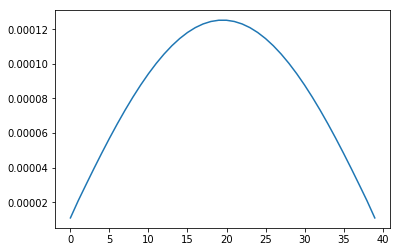

In [111]:
n_iter = 5000

flux_new = np.ones([n_cells_x,n_cells_y])
flux_old = np.zeros([n_cells_x,n_cells_y])
err = np.zeros([n_cells_x,n_cells_y])

norm = np.sum(flux_new)
flux_new = flux_new / norm
k_new = 1.0

for i in range(n_iter):
    b_new = rhs(flux_new,k_new)
    flux_new, leak = sweep(b_new)
    k_old = k_new
    f_new, a_new = balance(flux_new)
    k_new = f_new / (a_new + leak)
    norm = np.sum(flux_new)
    flux_new = flux_new / norm
    print(i,k_new, np.amax(err))
    if np.abs(k_new-k_old)/k_new < 1e-4:
        for m in range(n_cells_x):
            for n in range(n_cells_y):
                err[m,n] = np.abs((flux_new[m,n]-flux_old[m,n])/flux_new[m,n])
        if np.amax(err) < 1e-4:
            print(i)
            print(k_new)
            break
    flux_old = flux_new
plt.plot(flux_new[0,:])

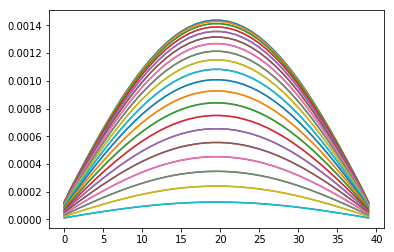

In [112]:
plt.plot(flux_new)